# **THOT calibration**

_by Felix Eickemeyer_

Calibration of raw data.
Based on calibrate 1.2.0.ipynb

_Version 21.07.2021 in Python 3_

_Change log:_  
1.1.0: My package used  



In [ ]:
import re
import os
import sys
from thot import ThotProject
from os import getcwd, listdir
import importlib
from IPython import embed
from importlib import reload
import matplotlib.pyplot as plt

from FTE_analysis_libraries import PLQY as lqy
from FTE_analysis_libraries import Spectrum as spc

import pkg_resources
system_dir = pkg_resources.resource_filename('FTE_analysis_libraries', 'System_data')
cal_lamp_dir = pkg_resources.resource_filename('FTE_analysis_libraries', 'System_data/Calibration_lamp_spectra')

reload(spc)
reload(lqy)
pass

In [ ]:
# Initializes Thot project
db = ThotProject( dev_root = r'PLQY_results\PLQY' )

In [10]:
#File extension for raw data
file_ext = 'csv'
#file_ext = 'asc'

# Gigahertz calibration lamp
lamp_spec_FN = 'caldata-BN-LH250-V01_sn51102-LH250_snL2229-200805.txt'
hole_diameter = 3e-3 #m

<<<<<<< local


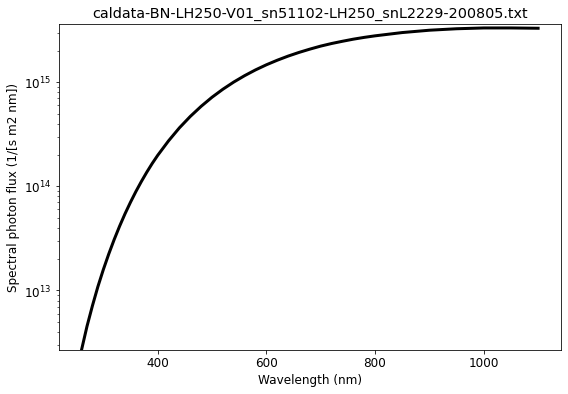

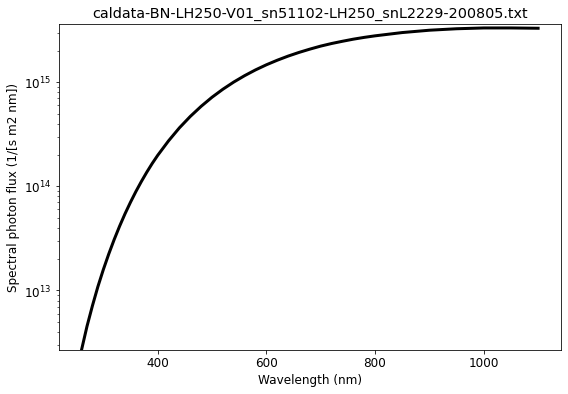

>>>>>>> remote


In [11]:
# Load lamp calibration file
lampspec_irr = spc.PEL_spectrum.load(cal_lamp_dir, lamp_spec_FN, header = 1, delimiter = '\t', 
                             quants = dict(x = 'Wavelength', y = 'Spectral irradiance'), units = dict(x = 'nm', y = 'W/[m2 nm]'))

#lampspec = lamp_calib * 1 # change for absolute calibration taking into account excitation port aperture of integrating sphere
lampspec = lampspec_irr.irradiance_to_photonflux(factor = 1e-6/1e-4)
#plot_first_n_lines(cal_lamp_dir, lamp_spec_FN, n=20)
lampspec_graph = lampspec.plot(yscale = 'log', return_fig = True, show_plot = False)
lqy.add_graph(db, 'lampspec.png', lampspec_graph)

<<<<<<< local


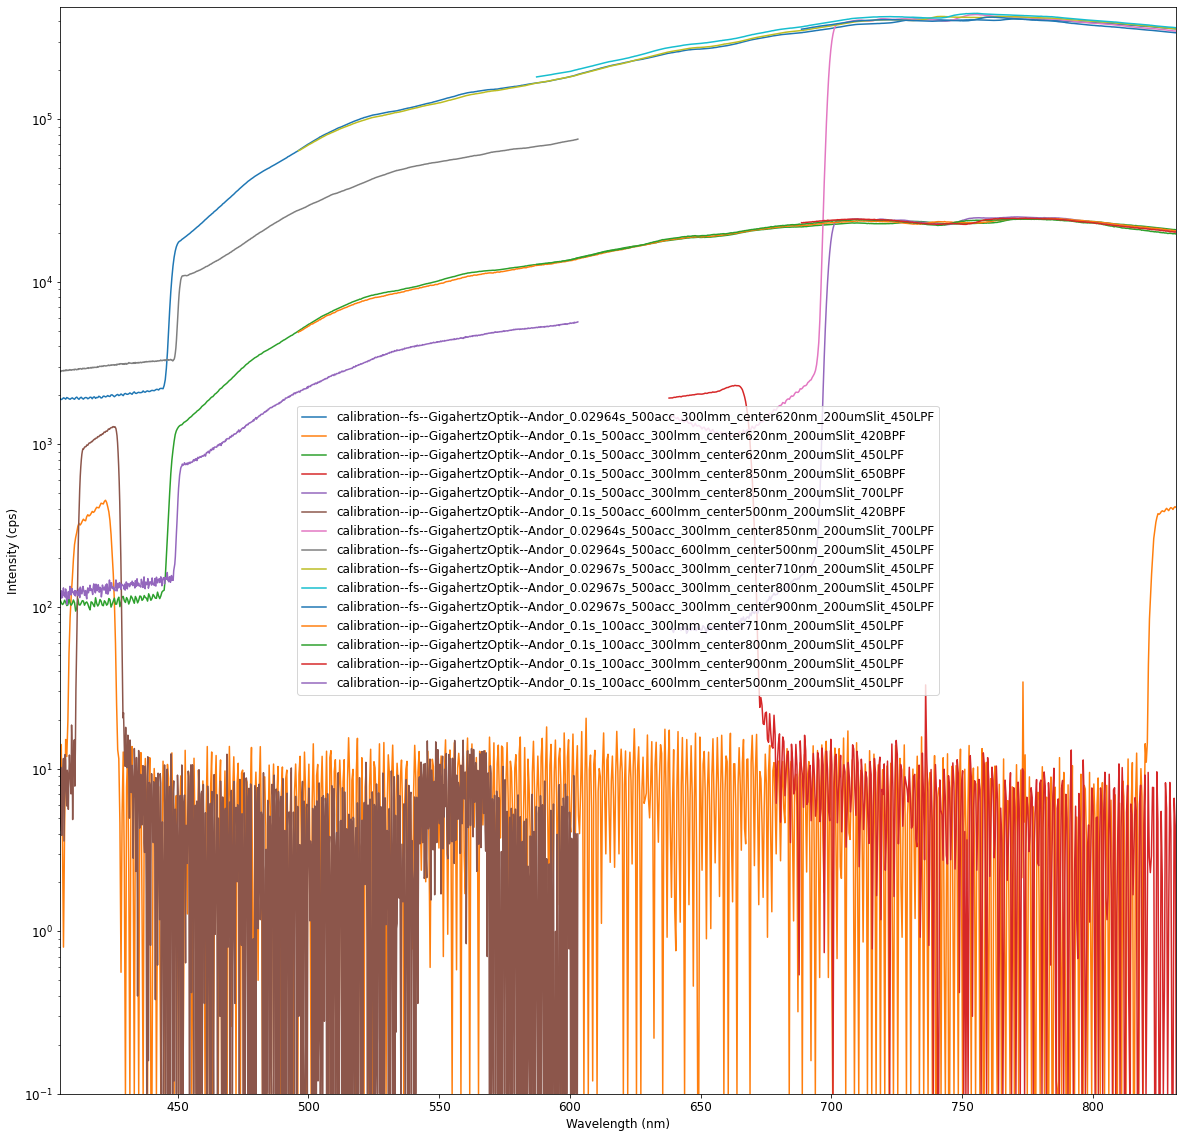

\\?\C:\Users\dreickem\switchdrive\Work\Python\PL\Steady_state_PL\thot\PLQY_results\PLQY\calibration\calibration--ip--GigahertzOptik--Andor_0.1s_500acc_300lmm_center620nm_200umSlit_420BPF\calibration--ip--GigahertzOptik--Andor_0.1s_500acc_300lmm_center620nm_200umSlit_420BPF.csv
calibration--ip--GigahertzOptik--Andor_0.1s_500acc_300lmm_center620nm_200umSlit_420BPF.csv
\\?\C:\Users\dreickem\switchdrive\Work\Python\PL\Steady_state_PL\thot\PLQY_results\PLQY\calibration\calibration--ip--GigahertzOptik--Andor_0.1s_500acc_300lmm_center620nm_200umSlit_420BPF
\\?\C:\Users\dreickem\switchdrive\Work\Python\PL\Steady_state_PL\thot\PLQY_results\PLQY\calibration\calibration--ip--GigahertzOptik--Andor_0.1s_500acc_300lmm_center620nm_200umSlit_450LPF\calibration--ip--GigahertzOptik--Andor_0.1s_500acc_300lmm_center620nm_200umSlit_450LPF.csv
calibration--ip--GigahertzOptik--Andor_0.1s_500acc_300lmm_center620nm_200umSlit_450LPF.csv
\\?\C:\Users\dreickem\switchdrive\Work\Python\PL\Steady_state_PL\thot\PLQY_

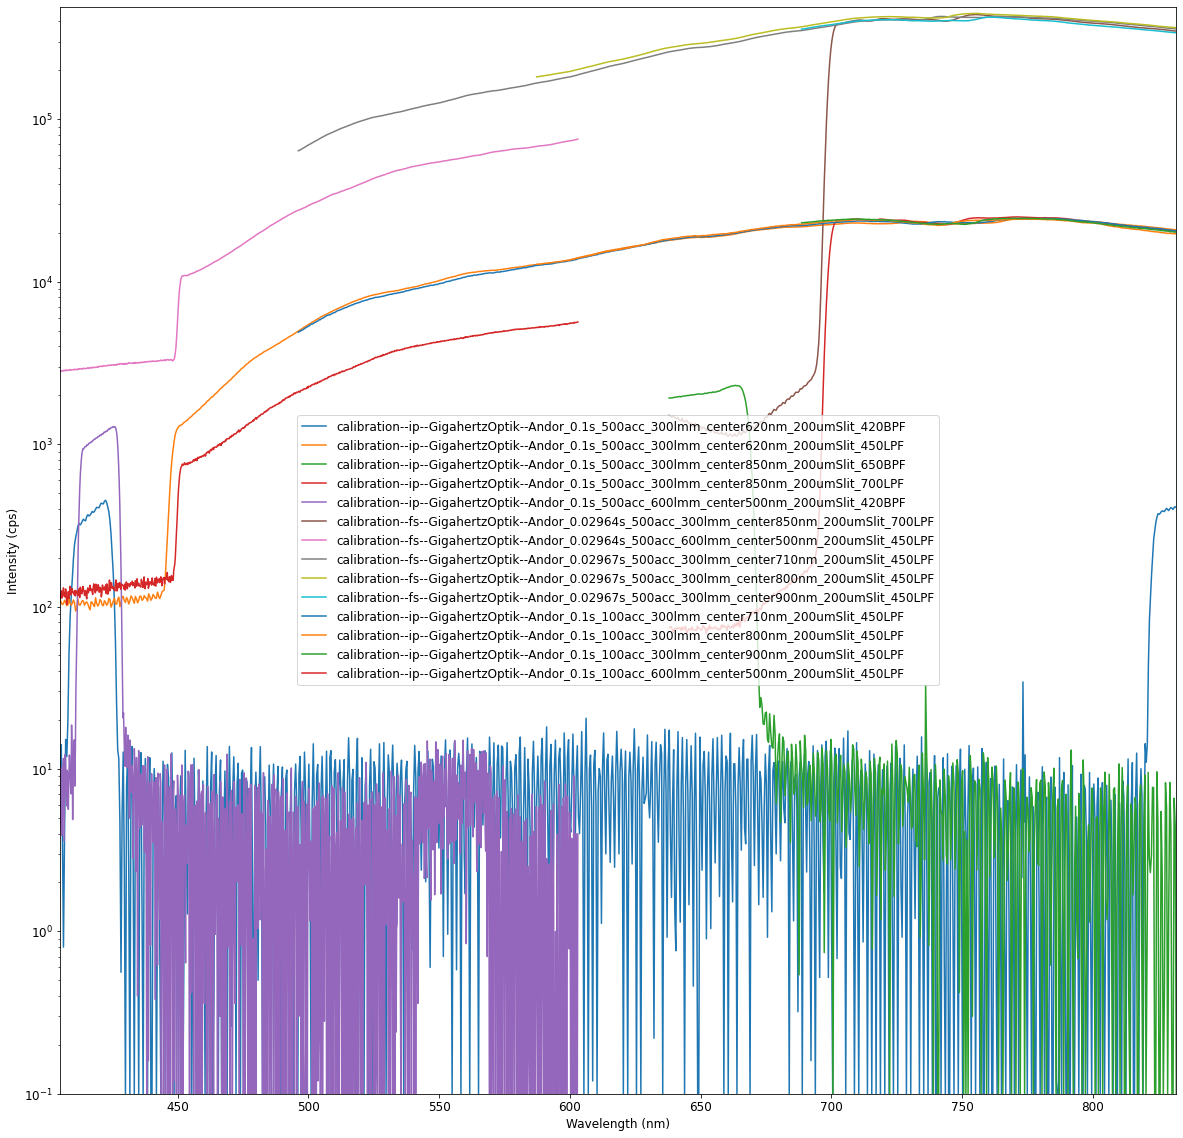

>>>>>>> remote


In [ ]:
# Load measured calibration spectra
rawcalib = db.find_assets({'type' : 'raw calibration'})
#print(dir(rawcalib[1]))
#print(rawcalib[3].file)
#print(rawcalib[1].metadata)
sa = []
for i, asset in enumerate(rawcalib[1:]):
    fp = asset.file
#     print(fp)
    fn = os.path.basename(fp)
#     print(fn)
    directory = os.path.dirname(fp)
#     print(directory)
    acc = asset.metadata['acc']
    int_s = asset.metadata['int_s']
    calib = spc.PEL_spectrum.load(directory, fn, quants = dict(x = 'Wavelength', y = 'Intensity'), units = dict(x = 'nm', y = 'cps'))
    calib.y = calib.y / (int_s * acc)
    sa.append(calib)
calib = spc.PEL_spectra(sa)
calib.names_to_label('.' + file_ext)

# Make sure that no data value is < min (especially not 0 or negative)
calib.all_values_greater_min(min = 1e-1)        

calibspec_graph = calib.plot(yscale = 'log', figsize = (20,20), return_fig = True, show_plot = False)
lqy.add_graph(db, 'calibration_spectra.png', calibspec_graph)

Attention: bottom = 0, use a divisor to self-define the bottom = top/divisor, here divisor = 1e8 is used as standard!


<<<<<<< local


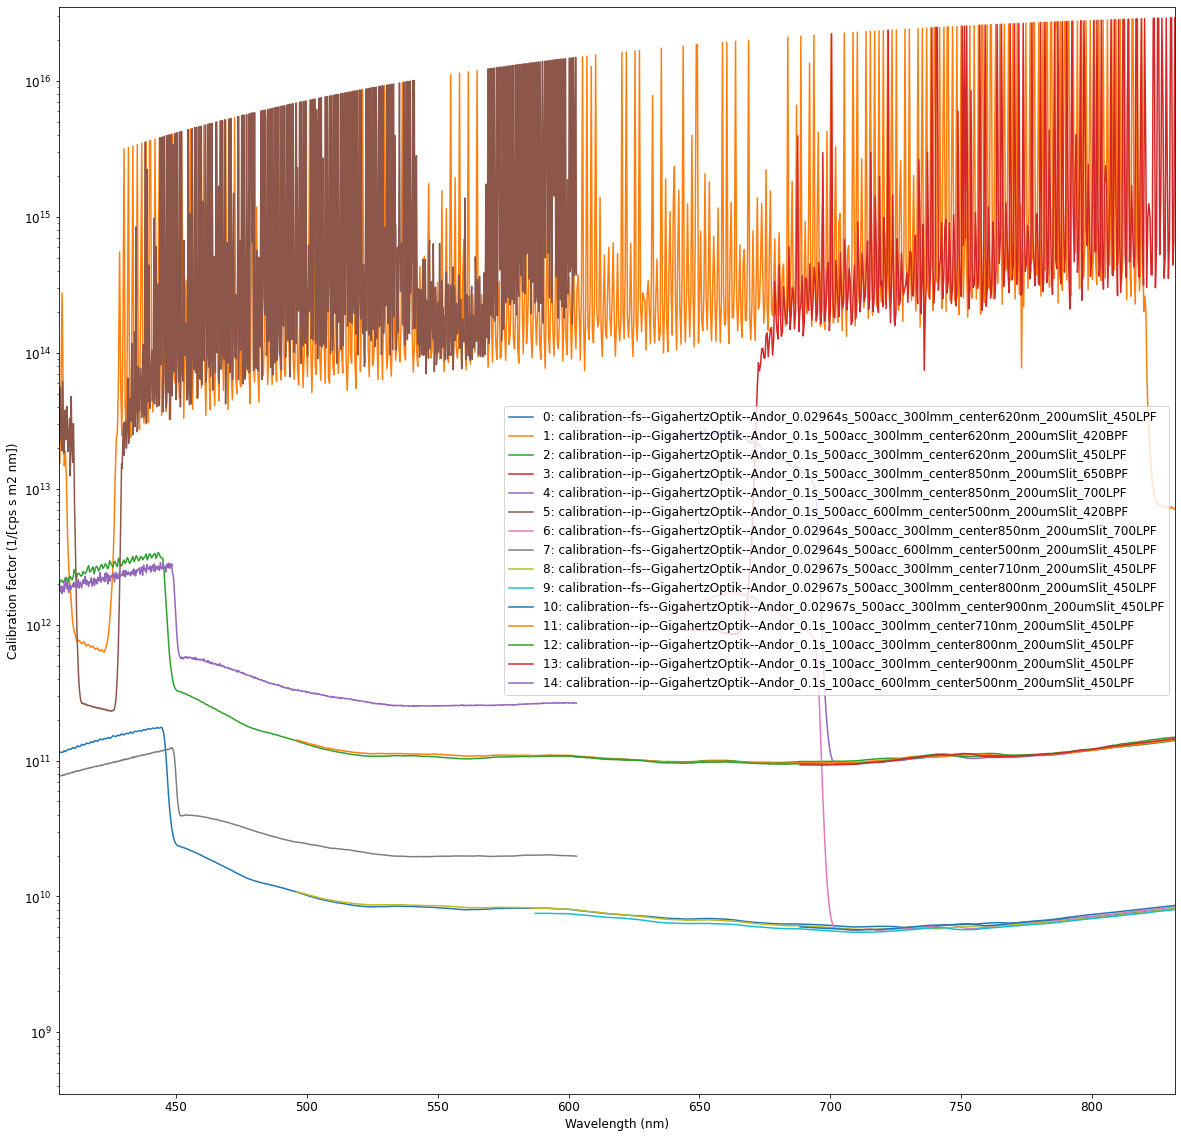

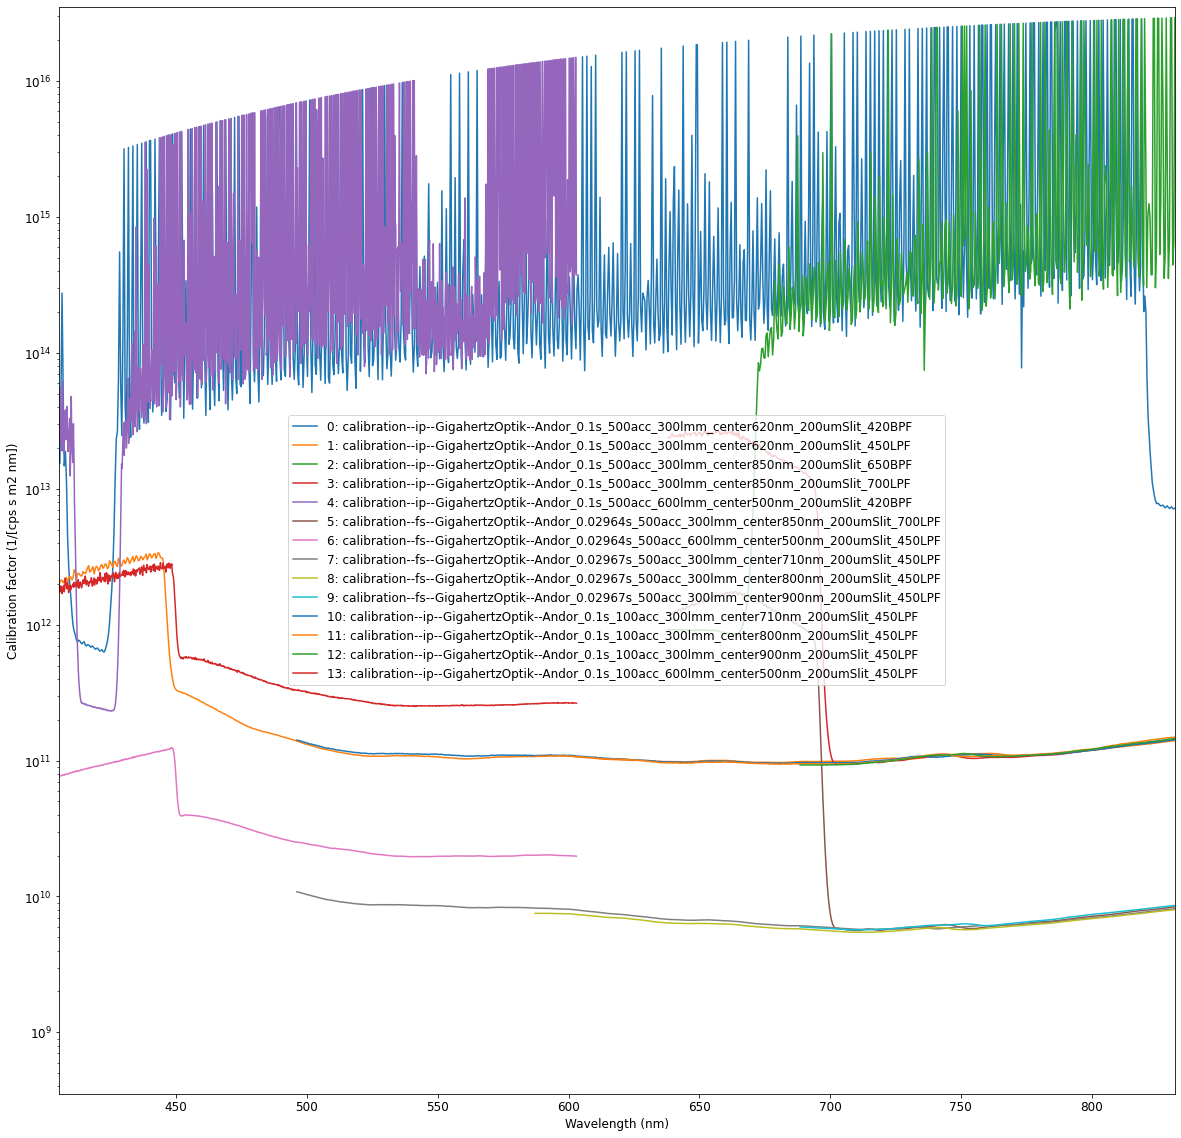

>>>>>>> remote


In [ ]:
# Calculate calibration function. This function is multiplied with all cps data to yield photon flux
calibfn = spc.PEL_spectra.calc_calfn(calib, lampspec)
calibfn.names_to_label('.csv')

calibfn_graph = calibfn.plot(yscale = 'log', showindex = True, figsize = (20,20), return_fig = True, show_plot = False)
lqy.add_graph(db, 'calibration_function.png', calibfn_graph)

In [ ]:
# Plot single calibration function
do_this_step1 = False
if do_this_step1:
    idx = 3
    #cal_lamp_Andor.sa[idx].plot(yscale = 'linear')
    calibfn.sa[idx].plot(yscale = 'log', bottom = 8e8, top = 10e10)

In [ ]:
# Savgol filter for selected calibration function (700 LP free space)
do_this_step2 = False
if do_this_step2:
    idx = 3
    calibfn_old = calibfn.sa[idx]
    calibfn_new = calibfn_old.savgol(n1 = 11, n2 = 1)
    both = spectra([calibfn_old, calibfn_new])
    both.label(['original', 'savgol'])
    both.plot(yscale = 'log', bottom = 8e8, top = 2e9, title = calibfn.sa[idx].name)
    take_over_calib_new = True
    if take_over_calib_new:
        calibfn.sa[idx] = calibfn_new

In [ ]:
# Load all PL raw spectra
rawsamples = db.find_assets({'type' : 'raw PL spectrum'})
#print(rawsamples)
#print(rawsamples[1].file)
#print(rawsamples[1].metadata)
sa = []
for i, asset in enumerate(rawsamples):
    fp = asset.file
    fn = os.path.basename(fp)
    directory = os.path.dirname(fp)
    acc = asset.metadata['acc']
    int_s = asset.metadata['int_s']
    rawPLspectrum = spc.PEL_spectrum.load(directory, fn, quants = dict(x = 'Wavelength', y = 'Intensity'), units = dict(x = 'nm', y = 'cps'))
    rawPLspectrum.y = rawPLspectrum.y / (int_s * acc)
    sa.append(rawPLspectrum)
rawPLspectra = spc.PEL_spectra(sa)
rawPLspectra.names_to_label('.' + file_ext)
#rawPLspectra.plot(yscale = 'log',figsize = (20,20), divisor = 1e7, showindex = True)    

In [ ]:
# Plot single raw spectrum
do_this_step3 = False
if do_this_step3:
    idx = 59
    rawPLspectra.sa[idx].plot(yscale = 'linear', left = PL_signal_left, right = PL_signal_right, figsize = (20,10))    

Calibrate

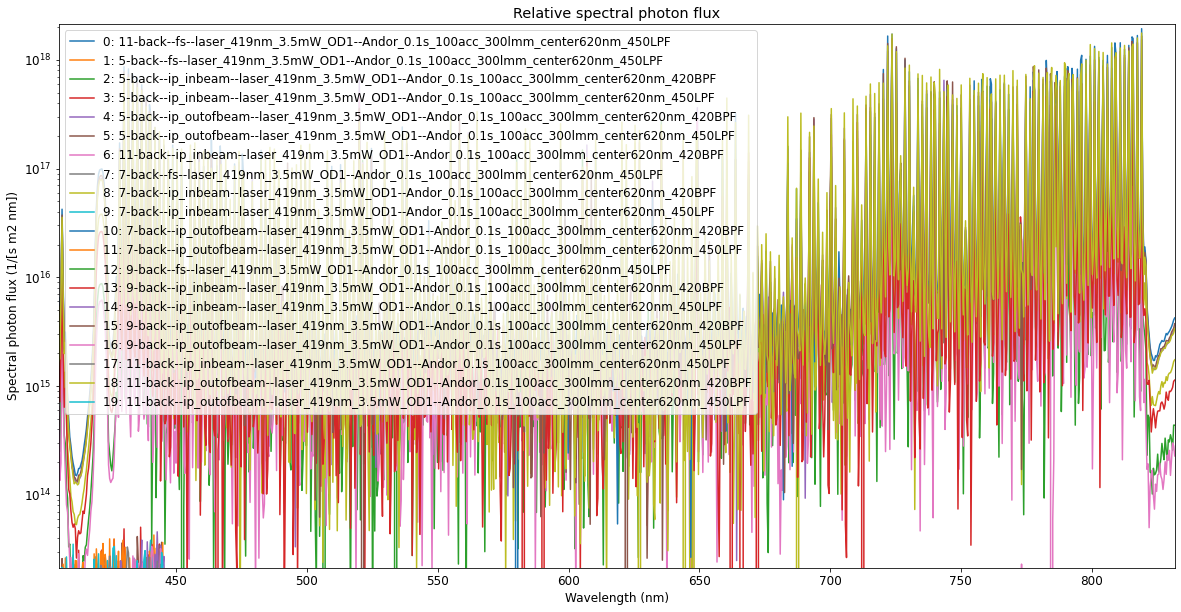

In [ ]:
# Calibrate PL spectra
PLspectra_nm = rawPLspectra.calibrate(calibfn, check = False)
PLspectra_nm.names_to_label(split_ch = '.' + file_ext)

calib_PLspectra_graph = PLspectra_nm.plot(yscale = 'log', divisor = 1e5, title = 'Relative spectral photon flux', showindex = True, figsize = (20, 10), return_fig = True, show_plot = False)
lqy.add_graph(db, 'calib_PLspectra.png', calib_PLspectra_graph)

Create new asset

In [ ]:
for idx, sp in enumerate(PLspectra_nm.sa):
    print(sp.name)
    asset = db.find_asset({'metadata.orig_fn' : sp.name})
    metadata = asset.metadata
    #print(metadata)
    #asset_prop = dict(name = 'calibrated_'+asset.name, type = 'calibrated PL spectrum', metadata = metadata)
    name = metadata['name']
    asset_prop = dict(name = f'{idx}_{name}_calibrated PL spectrum.csv', type = 'calibrated PL spectrum', metadata = metadata)
    TFN = db.add_asset(asset_prop)
    fn = os.path.basename(TFN)
    print(f'{idx: 3}: {fn}') 
    directory = os.path.dirname(TFN)
    sp.save(directory, fn, check_existing = False)


11-back--fs--laser_419nm_3.5mW_OD1--Andor_0.1s_100acc_300lmm_center620nm_450LPF.csv
5-back--fs--laser_419nm_3.5mW_OD1--Andor_0.1s_100acc_300lmm_center620nm_450LPF.csv
5-back--ip_inbeam--laser_419nm_3.5mW_OD1--Andor_0.1s_100acc_300lmm_center620nm_420BPF.csv
5-back--ip_inbeam--laser_419nm_3.5mW_OD1--Andor_0.1s_100acc_300lmm_center620nm_450LPF.csv
5-back--ip_outofbeam--laser_419nm_3.5mW_OD1--Andor_0.1s_100acc_300lmm_center620nm_420BPF.csv
5-back--ip_outofbeam--laser_419nm_3.5mW_OD1--Andor_0.1s_100acc_300lmm_center620nm_450LPF.csv
11-back--ip_inbeam--laser_419nm_3.5mW_OD1--Andor_0.1s_100acc_300lmm_center620nm_420BPF.csv
7-back--fs--laser_419nm_3.5mW_OD1--Andor_0.1s_100acc_300lmm_center620nm_450LPF.csv
7-back--ip_inbeam--laser_419nm_3.5mW_OD1--Andor_0.1s_100acc_300lmm_center620nm_420BPF.csv
7-back--ip_inbeam--laser_419nm_3.5mW_OD1--Andor_0.1s_100acc_300lmm_center620nm_450LPF.csv
7-back--ip_outofbeam--laser_419nm_3.5mW_OD1--Andor_0.1s_100acc_300lmm_center620nm_420BPF.csv
7-back--ip_outofbeam

In [ ]:
sys.exit()

# Supplemental code

In [ ]:
#Plot all data normalized within [left, right]
do_this = False
if do_this:
    left = PL_signal_left
    right = PL_signal_right

    spa2 = PLspectra_nm.copy()
    spa2.names_to_label()
    for idx, sp in enumerate(spa2.sa):
        r = range(findind(sp.x, left), findind(sp.x, right))
        print(f'{sp.name}: max = {max(sp.y[r]):.1e}')
        sp.normalize(x_lim = [left, right])
        m = 1

    #spa2.plot(yscale = 'log', title = 'Relative spectral photon flux', left = left, right = right, bottom = m*1e-2, top = m*1.1, figsize = (30, 20), nolabel = False)

In [ ]:
PLspectra_nm.plot(yscale = 'linear', bottom = 0, title = 'Relative spectral photon flux', showindex = True, figsize = (20, 10), in_name = ['fs'])